In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import d2l
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve, auc

### Define NN


In [2]:
class Net(nn.Module):
    def __init__(self,features,H1,H2,classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(features, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Multi-class Classification

In [3]:
def load_data(path):
    """
    Load the .npz data according to path
    """
    file = np.load('datasets/multi-class/'+path+'.npz') #read
    train_X,train_Y,test_X,test_Y = file['train_X'],file['train_y'],file['test_X'],file['test_y']
    return train_X,train_Y,test_X,test_Y

In [4]:
def find_optimal_unit_size(train_X,train_Y,epochs,batch_size,lr):
    """
    Find the best H1 & H2 using cross-validation
    """
    LOSS,ACC = [],[]
    classes = 10
    
    index_80 = np.random.choice(range(len(train_X)),size = int(0.8*len(train_X)),replace=False) #randomly select 80% index of train
    index_20 = list(set(range(len(train_X))) - set(index_80)) #the remained 20% index for validation
    train_X_80,train_Y_80 = train_X[index_80,:],train_Y[index_80] #split
    train_X_20,train_Y_20 = train_X[index_20,:],train_Y[index_20] #split
    
    params = []
    for H1 in [15,25,50]: #For each hidden unit
        for H2 in [5,10,20]:
            params.append((H1,H2)) #record the parameters combination
            
            # network
            net = Net(train_X.shape[1],H1,H2,classes)
            # loss
            criterion = nn.CrossEntropyLoss()
            # optimizer
            optimizer = optim.SGD(net.parameters(), lr=lr)
            # lr scheduler
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98, last_epoch=-1, verbose=False)
            
            for m in net.modules(): #Initialization
                if isinstance(m, (nn.Conv2d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight)

            for epoch in range(epochs):
                start,n = 0,len(train_X_80)
                while start < n: #Mini-batch-gradient-descent
                    end = min(n,start+batch_size)
                    X = torch.Tensor(train_X_80[start:end,:]).float()
                    Y = torch.Tensor(train_Y_80[start:end]).long()
                    optimizer.zero_grad()
                    out = net(X) 
                    loss = criterion(out, Y)
                    loss.backward() 
                    optimizer.step()
                    start += batch_size
                scheduler.step()
                
            #Evalaute the model in last 20% training data
            X = torch.Tensor(train_X_20).float()
            Y = torch.Tensor(train_Y_20).long()
            out = net(X)
            loss = criterion(out, Y)
            _, predicted = torch.max(out.data, 1)
            acc = torch.sum(Y==predicted).double() / len(Y)
            LOSS.append(loss.detach().numpy())
            ACC.append(acc)

    H1,H2 = params[LOSS.index(min(LOSS))] #find the best h according to minimum loss value
    return H1,H2,LOSS,ACC

In [5]:
def predict(h1,h2,train_X,train_Y,test_X,test_Y,epochs,batch_size,lr):
    """
    Predict the testing dataset using the best H
    """
    net = Net(train_X.shape[1],h1,h2,10)
    # loss
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98, last_epoch=-1, verbose=False)
    
    for m in net.modules():#initialization
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            
    for epoch in range(epochs):
        start,n = 0,len(train_X)
        while start < n:#Mini-batch-gradient-descent
            end = min(n,start+batch_size)
            X = torch.Tensor(train_X[start:end,:]).float()
            Y = torch.Tensor(train_Y[start:end]).long()
            optimizer.zero_grad()
            out = net(X) 
            loss = criterion(out, Y)
            loss.backward() 
            optimizer.step()
            start += batch_size  
        scheduler.step()
        
    #get prediction
    X_train = torch.Tensor(train_X).float()
    Y_train = torch.Tensor(train_Y).long()
    out_train = net(X_train)
    loss_train = criterion(out_train, Y_train)

    X_test = torch.Tensor(test_X).float()
    Y_test = torch.Tensor(test_Y).long()
    out_test = net(X_test)
    loss_test = criterion(out_test, Y_test)
    return loss_train.detach().numpy(),out_train,loss_test.detach().numpy(),out_test

In [6]:
def analyze_prediction(path,train_Y,test_Y,out_train,out_test):
    """
    Get the Accuracy of Test set and plot the confusion matrix
    """
    train_Y = torch.Tensor(train_Y).long() #convert to tensor
    test_Y = torch.Tensor(test_Y).long() #convert to tensor
    
    train_predicted = torch.max(out_train.data, 1)[1] #compute true prediction
    test_predicted = torch.max(out_test.data, 1)[1]
    
    train_acc = torch.sum(train_Y==train_predicted).double() / len(train_Y) #calculate accuracy
    test_acc = torch.sum(test_Y==test_predicted).double() / len(test_Y)
    
    sns.set()
    plt.style.use(['science','ieee','std-colors','no-latex'])
    f,ax=plt.subplots(figsize=[4,4],dpi=150)
    C2= confusion_matrix(test_Y, test_predicted) #confusion matrix
    sns.heatmap(C2,annot=True,ax=ax) 
    ax.set_title('confusion matrix of '+path) 
    ax.set_xlabel('predict') 
    ax.set_ylabel('true')
    plt.savefig('confusion_matrix_multi_'+path+'.png',dpi=200)
    
    return train_acc,test_acc

The best H1 and H2 for digits are 25 and 20
The Training Loss is 0.03577025607228279, The Testing Loss is 0.4036158621311188
The Training accuracy is 0.9930410577592206, The Testing accuracy is 0.8944444444444445
------------------------------


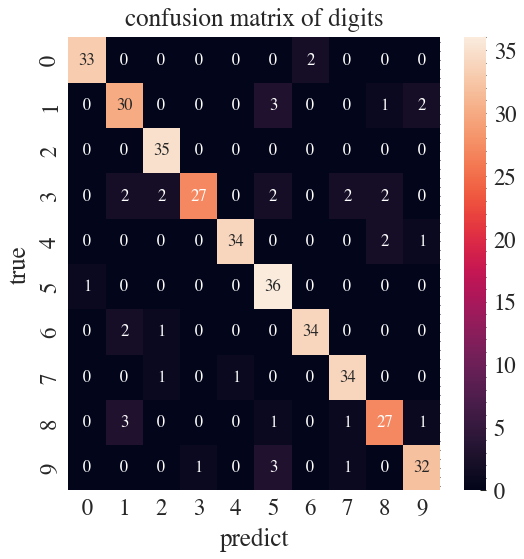

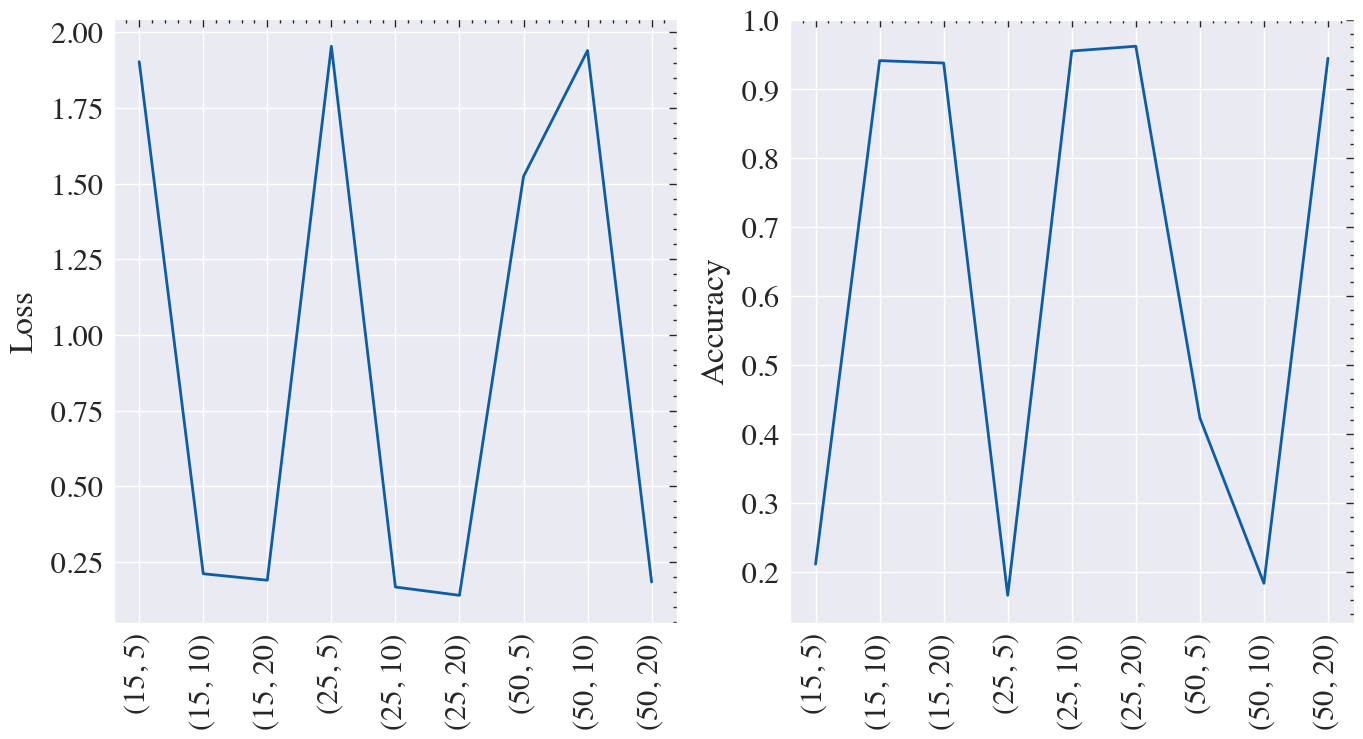

In [8]:
if __name__ == "__main__":
    #training params
    epochs = 1000
    batch_size = 256
    lr = 0.05
    path = 'digits'

    train_X,train_Y,test_X,test_Y = load_data(path) #get data
    h1,h2,LOSS, ACC= find_optimal_unit_size(train_X,train_Y,epochs,batch_size,lr) #get h1, h2,  and tuning process
    print('The best H1 and H2 for {} are {} and {}'.format(path,h1,h2))
    loss_train,out_train,loss_test,out_test = predict(h1,h2,train_X,train_Y,test_X,test_Y,epochs,batch_size,lr) #get loss and prediciton of testset
    print('The Training Loss is {}, The Testing Loss is {}'.format(loss_train,loss_test))
    train_acc,test_acc = analyze_prediction(path,train_Y,test_Y,out_train,out_test) #analyze the prediction performance
    print('The Training accuracy is {}, The Testing accuracy is {}'.format(train_acc,test_acc))
    print("------------------------------")
        
    #plot the parameter selection process
    plt.style.use(['science','ieee','std-colors','no-latex'])
    fig = plt.figure(figsize=[8,4],dpi=200)
    fig.patch.set_facecolor('#FFFFFF')
    plt.grid(color='grey', linestyle='-.', linewidth=0.2)
    plt.subplot(1,2,1)
    plt.plot(range(9),LOSS)
    plt.xticks(ticks=range(9),labels=[(15,5),(15,10),(15,20),(25,5),(25,10),(25,20),(50,5),(50,10),(50,20)])
    plt.xticks(rotation=90)
    plt.ylabel('Loss')
    plt.subplot(1,2,2)
    plt.plot(range(9),ACC)
    plt.xticks(ticks=range(9),labels=[(15,5),(15,10),(15,20),(25,5),(25,10),(25,20),(50,5),(50,10),(50,20)])
    plt.xticks(rotation=90)
    plt.ylabel('Accuracy')
    plt.savefig('multi_exp.png',dpi=200)